#Kaggle API

In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
! kaggle datasets download -d pcbreviglieri/pneumonia-xray-images

Dataset URL: https://www.kaggle.com/datasets/pcbreviglieri/pneumonia-xray-images
License(s): Attribution 4.0 International (CC BY 4.0)
100% 1.14G/1.14G [00:04<00:00, 260MB/s]
100% 1.14G/1.14G [00:04<00:00, 273MB/s]


In [ ]:
import zipfile

zf = "/content/pneumonia-xray-images.zip"
target_dir = "/content/dataset/cnn/pneumonia_revamped"

zfile = zipfile.ZipFile(zf)
zfile.extractall(target_dir)

# 1 Set up

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## 1.1 Define Constants

In [ ]:
train_path = '/content/dataset/cnn/pneumonia_revamped/train'
test_path = '/content/dataset/cnn/pneumonia_revamped/test'
valid_path = '/content/dataset/cnn/pneumonia_revamped/val'

In [ ]:

#Define standard parameter values
batch_size = 16
img_height = 500
img_width = 500


# 2 Preparing Data

## 2.2 Image Data Augmentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img

image_gen = ImageDataGenerator(
                                   rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,

                               )

test_data_gen = ImageDataGenerator(rescale = 1./255)



train = image_gen.flow_from_directory(
    train_path,
    target_size=(img_height, img_width),
    color_mode='grayscale',
    class_mode='binary',
    batch_size=batch_size
                                      )

test = test_data_gen.flow_from_directory(
      test_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',shuffle=False,
      class_mode='binary',
      batch_size=batch_size
      )
valid = test_data_gen.flow_from_directory(
      valid_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      class_mode='binary',
      batch_size=batch_size
      )

Found 4192 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 1040 images belonging to 2 classes.


In [ ]:
type(train)

keras.src.preprocessing.image.DirectoryIterator

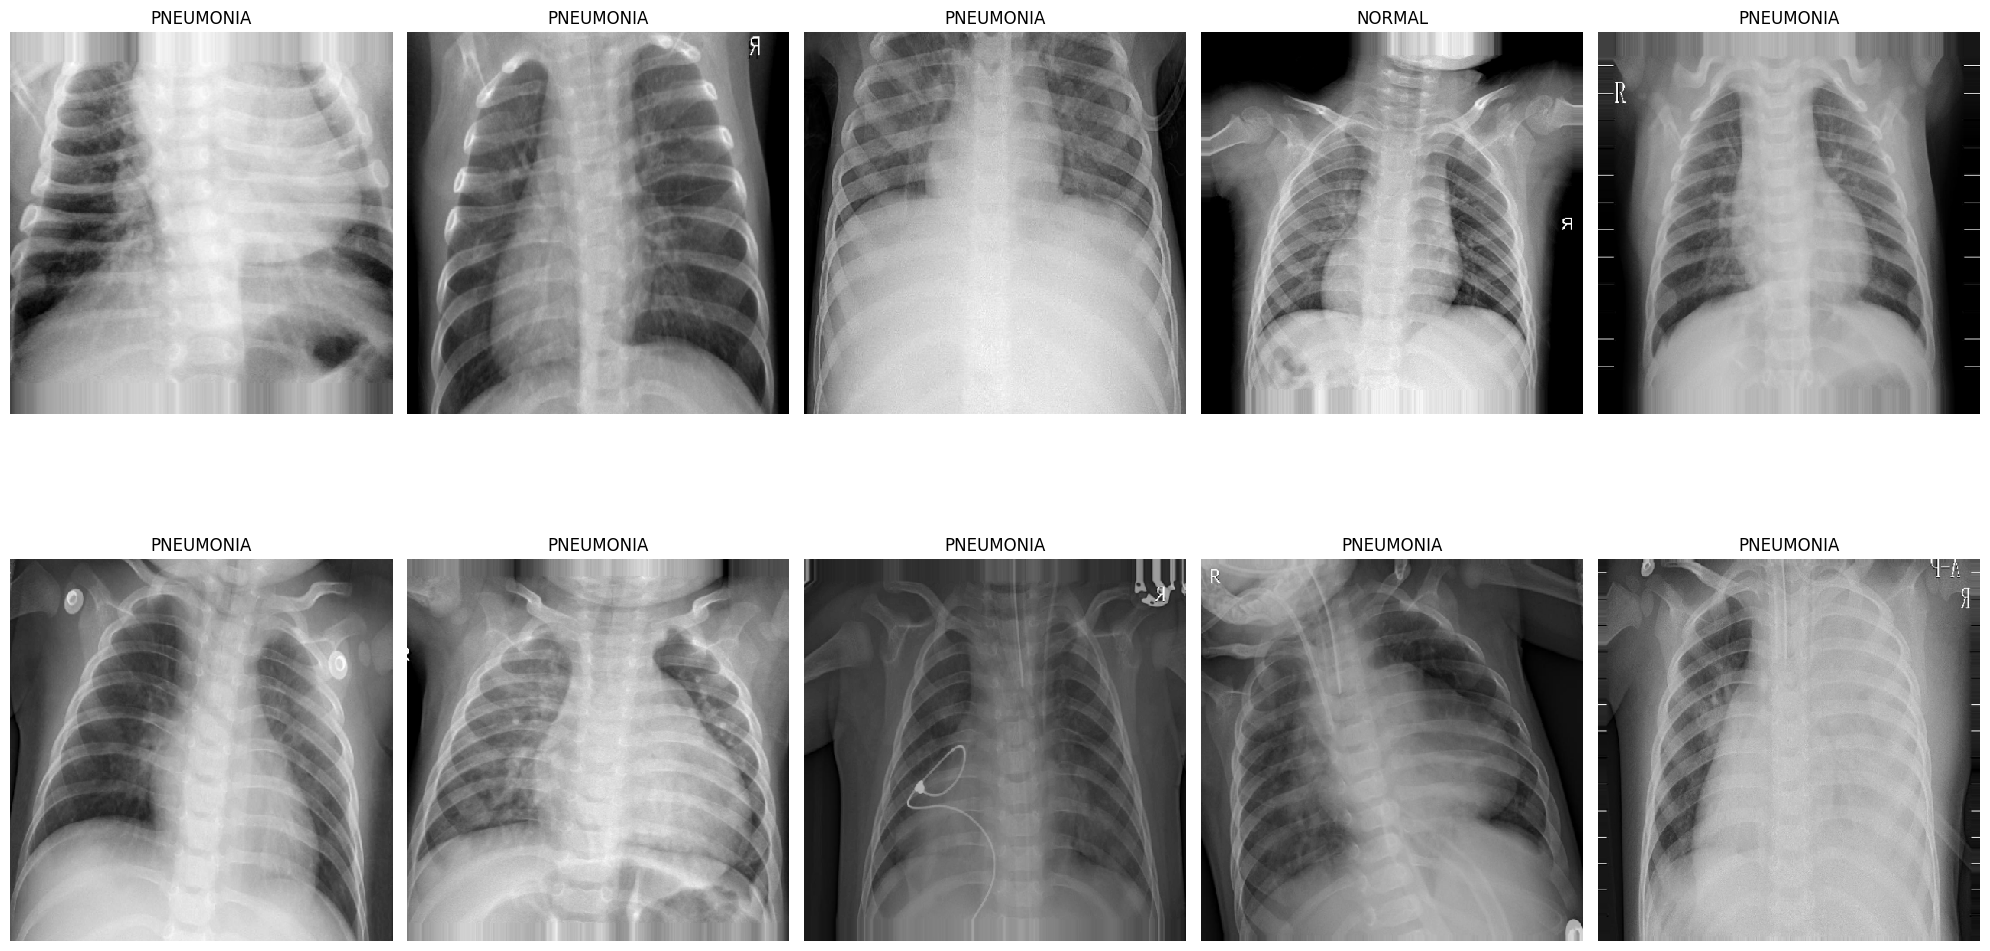

In [ ]:
plt.figure(figsize=(20, 12))
for i in range(0, 10):
    plt.subplot(2, 5, i+1)
    for X_batch, Y_batch in train:
        image = X_batch[0]
        dic = {0:'NORMAL', 1:'PNEUMONIA'}
        plt.title(dic.get(Y_batch[0]))
        plt.axis('off')
        plt.imshow(np.squeeze(image),cmap='gray',interpolation='nearest')
        break
plt.tight_layout()
plt.show()

### Define

In [ ]:
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening

        rotation_range = 15,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False,# randomly flip images
        shear_range=0.2,
        brightness_range=(1.2, 1.5)

# 3 Tensorflow - Keras

In [ ]:
from tensorflow.keras.models import Sequential,load_model,save_model
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

## 3.1 Convolutional Neural Network Model

In [ ]:
# let's build the CNN model

cnn = Sequential()

cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Flatten())

cnn.add(Dense(activation = 'relu', units = 128))
cnn.add(Dense(activation = 'relu', units = 64))
cnn.add(Dense(activation = 'sigmoid', units = 1))


cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 498, 498, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 249, 249, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 247, 247, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 123, 123, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 121, 121, 32)      9248      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 60, 60, 32)        0

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(cnn,show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


## 3.2 Fit Model

In [ ]:
early = EarlyStopping(monitor="val_loss",
                      mode="min",
                      patience=2)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

callbacks_list = [ early, learning_rate_reduction]

In [ ]:
from sklearn.utils import compute_class_weight
class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(train.classes),
                                        y = train.classes
                                    )
class_weights = dict(zip(np.unique(train.classes), class_weights))
class_weights

{0: 1.9371534195933457, 1: 0.6739549839228296}

In [ ]:
cnn.fit(train,epochs=3, validation_data=valid, class_weight=class_weights, callbacks=callbacks_list)

Epoch 1/3
262/262 [==============================] - 233s 881ms/step - loss: 0.4497 - accuracy: 0.7493 - val_loss: 0.3347 - val_accuracy: 0.8721 - lr: 0.0010
Epoch 2/3
262/262 [==============================] - 229s 873ms/step - loss: 0.2863 - accuracy: 0.8881 - val_loss: 0.2892 - val_accuracy: 0.8702 - lr: 0.0010
Epoch 3/3
262/262 [==============================] - 228s 869ms/step - loss: 0.2572 - accuracy: 0.8967 - val_loss: 0.2137 - val_accuracy: 0.9163 - lr: 0.0010


In [ ]:
 fp = "/content/drive/My Drive/cnn_pneu_vamp_model.h5"
cnn.save(fp)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
fp = "/content/drive/My Drive/cnn_pneu_vamp_model.h5"
cnn = load_model(fp)

##3.3 Evaluation

In [ ]:
pd.DataFrame(cghh.plot())

NameError: name 'cghh' is not defined

In [ ]:
test_accu = cnn.evaluate(test)
print('The testing accuracy is :',test_accu[1]*100, '%')

39/39 [==============================] - 6s 156ms/step - loss: 0.4904 - accuracy: 0.8061
The testing accuracy is : 80.60897588729858 %


In [ ]:
preds = cnn.predict(test,verbose=1)

39/39 [==============================] - 6s 155ms/step


In [ ]:
predictions = preds.copy()
predictions[predictions <= 0.5] = 0
predictions[predictions > 0.5] = 1

<Axes: >

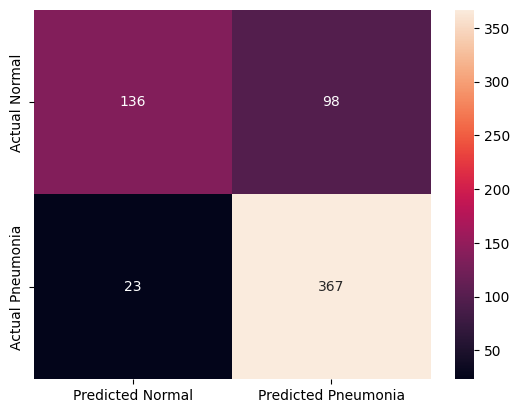

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix

cm = pd.DataFrame(data=confusion_matrix(test.classes, predictions, labels=[0, 1]),
                  index=["Actual Normal", "Actual Pneumonia"],
                  columns=["Predicted Normal", "Predicted Pneumonia"])
import seaborn as sns
sns.heatmap(cm,annot=True,fmt="d")

In [ ]:
 print(classification_report(y_true=test.classes, y_pred=predictions,
                            target_names =['NORMAL','PNEUMONIA']
 ))

              precision    recall  f1-score   support

      NORMAL       0.86      0.58      0.69       234
   PNEUMONIA       0.79      0.94      0.86       390

    accuracy                           0.81       624
   macro avg       0.82      0.76      0.78       624
weighted avg       0.81      0.81      0.80       624



In [ ]:
test.reset()
x=np.concatenate([test.next()[0] for i in range(test.__len__())])
y=np.concatenate([test.next()[1] for i in range(test.__len__())])
print(x.shape)
print(y.shape)

(624, 500, 500, 1)
(624,)


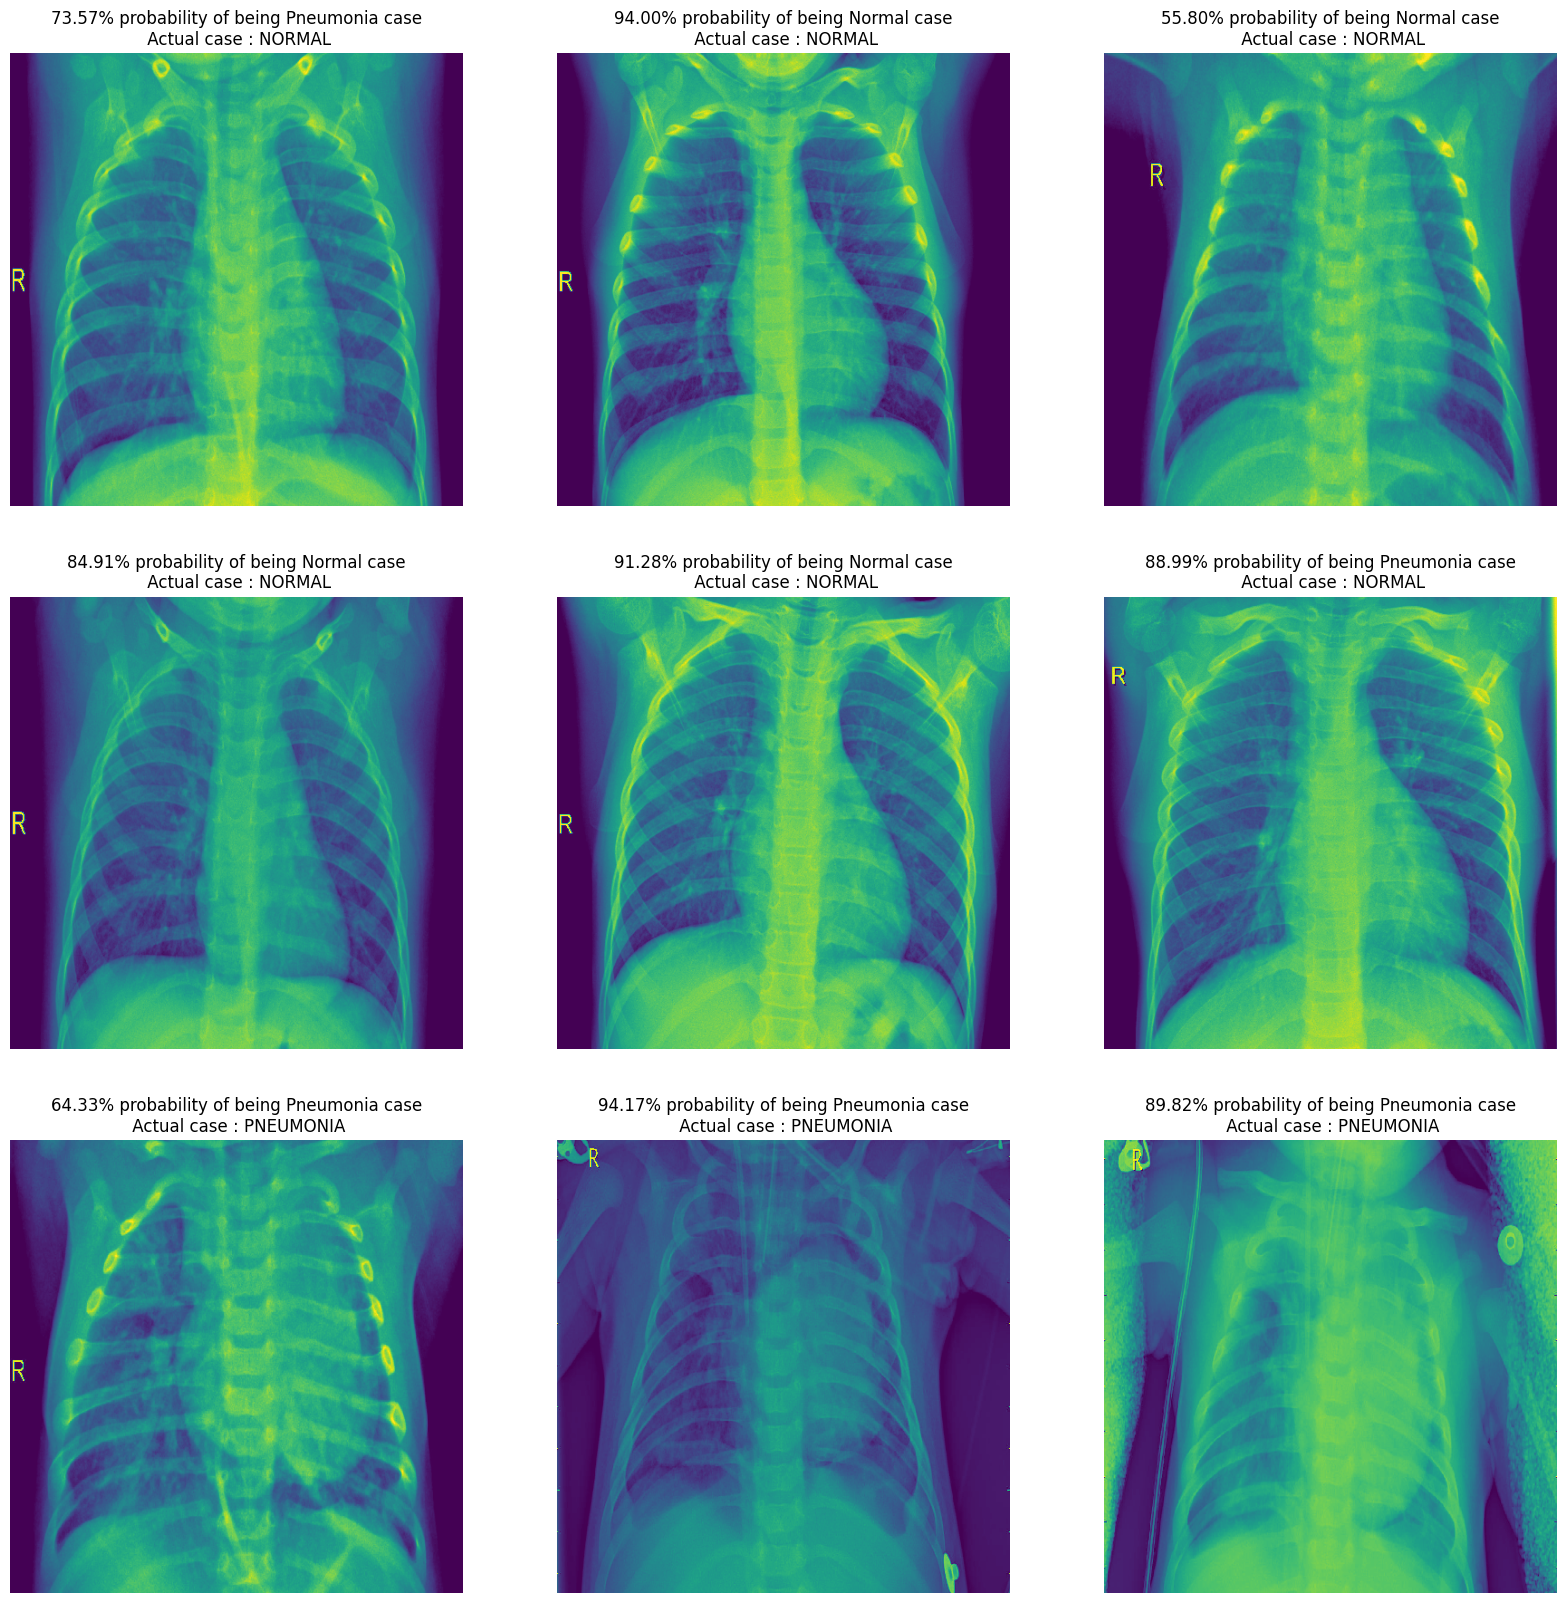

In [ ]:
dic = {0:'NORMAL', 1:'PNEUMONIA'}
plt.figure(figsize=(20,20))
for i in range(0+228, 9+228):
  plt.subplot(3, 3, (i-228)+1)
  if preds[i, 0] >= 0.5:
      out = ('{:.2%} probability of being Pneumonia case'.format(preds[i][0]))


  else:
      out = ('{:.2%} probability of being Normal case'.format(1-preds[i][0]))



  plt.title(out+"\n Actual case : "+ dic.get(y[i]))
  plt.imshow(np.squeeze(x[i]))
  plt.axis('off')
plt.show()

In [ ]:
import plotly.graph_objects as go
fig = go.Figure( go.Scatter(y=y ) )
fig.show()

In [ ]:
import plotly.graph_objects as go
fig = go.Figure( go.Scatter(y=predictions[:,0] ) )
fig.show()

1/1 [==============================] - 0s 111ms/step


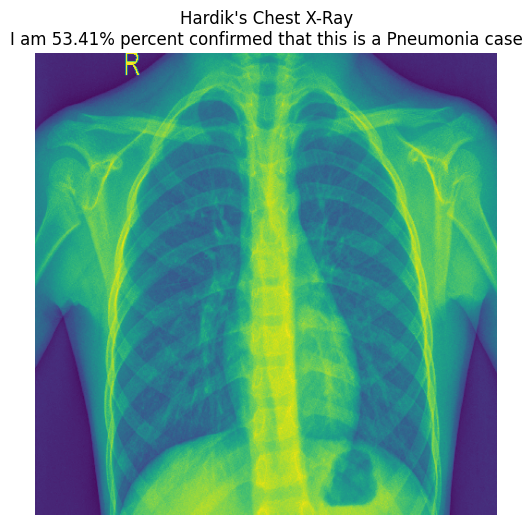

In [33]:
# Testing with my own Chest X-Ray
hardik_path = '/content/dataset/cnn/pneumonia_revamped/test/normal/IM-0001-0001.jpeg'

from tensorflow.keras.preprocessing import image

hardik_img = image.load_img(hardik_path, target_size=(500, 500),color_mode='grayscale')

# Preprocessing the image
pp_hardik_img = image.img_to_array(hardik_img)
pp_hardik_img = pp_hardik_img/255
pp_hardik_img = np.expand_dims(pp_hardik_img, axis=0)

#predict
hardik_preds= cnn.predict(pp_hardik_img)

#print
plt.figure(figsize=(6,6))
plt.axis('off')
if hardik_preds>= 0.5:
    out = ('I am {:.2%} percent confirmed that this is a Pneumonia case'.format(hardik_preds[0][0]))

else:
    out = ('I am {:.2%} percent confirmed that this is a Normal case'.format(1-hardik_preds[0][0]))


plt.title("Hardik's Chest X-Ray\n"+out)
plt.imshow(np.squeeze(pp_hardik_img))
plt.show()